In [1]:
!tree -dL 2 input/

input/

0 directories


In [2]:
# generic librairies
import time as time
import numpy as np
import pandas as pd
import gc

# Text librairies
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tag.util import untag
import contractions
# import pycontractions # Alternative better package for removing contractions
from autocorrect import Speller


from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mglearn
from cycler import cycler

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
#plt.rc('axes', prop_cycle=(
#    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
#    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']

# Load Data

In [3]:
%%time

# https://numpy.org/devdocs/user/basics.types.html

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str', 'Body': 'str', 'Text': 'str'}

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=['Id', 'Score', 'Title', 'Body','Text'], 
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=10000
                          )

CPU times: user 117 ms, sys: 15.8 ms, total: 132 ms
Wall time: 131 ms


In [4]:
df_questions

,Id,Title,Body,Score,Text
0,3624753,provide initialization subclass namedtuple,namedtuple like edgebase namedtupleedgebase le...,52,provide initialization subclass namedtuple nam...
1,14670299,use stargazer rstudio knitr,struggle use stargazer output knitr use exampl...,21,use stargazer rstudio knitr struggle use starg...
2,16476413,panda dataframe via mysqldb database,mysql database python create select row questi...,56,panda dataframe via mysqldb database mysql dat...
3,1173463,recommendation window text editor r,recommendation window text editor r use work r...,38,recommendation window text editor r recommenda...
4,10933945,norm vector r,norm think give result c sqrt return x error n...,45,norm vector r norm think give result c sqrt re...
...,...,...,...,...,...
9995,18292500,python log typeerror,could please help import log name loggingbasic...,22,python log typeerror could please help import ...
9996,17065086,get class name inside function another class p...,stimulate sequence diagram application need in...,34,get class name inside function another class p...
9997,13857,explain closure relate python,reading lot closure think understand without c...,88,explain closure relate python reading lot clos...
9998,9136539,edge affect pagerank networkx,play around graph python find documentation sa...,21,edge affect pagerank networkx play around grap...


In [5]:
text_train = df_questions.Text
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'pandas.core.series.Series'>
length of text_train: 10000
text_train[6]:
pas parameter shiny via url web browser pass parameter website like wwwmysitecomparameter shiny app would like use parameter pass site calculation input something like wwwmysitecomparameter use inputparameter provide sample code link thank


# Representer le texte en "Bag of Words"

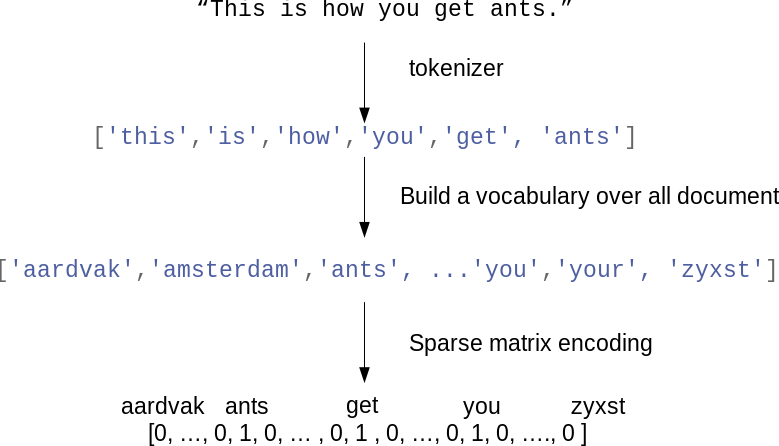

In [6]:
# faire un test de bag of words

bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [8]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [9]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [10]:
print("Dense representation of bag_of_words:\n{}".format(
    bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


## bag-of-words de Post

In [11]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<10000x50660 sparse matrix of type '<class 'numpy.int64'>'
	with 333486 stored elements in Compressed Sparse Row format>


In [12]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 5010 to 5030:\n{}".format(feature_names[5010:5030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 50660
First 20 features:
['aa', 'aaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaaaaaaaaadwpwaaaaaaaabaaaaaaaaaceaaaaaaaaaqqaaaaaaaabraaaaaaaaageaaaaaaaaacqaaaaaaaacbaaaaaaaaaikaaaaaaaaakqaaaaaaaaczaaaaaaaaakeaaaaaaaaaqqaaaaaaaacxaaaaaaaaalkaaaaaaaaawqaaaaaaaadfaaaaaaaaamkaaaaaaaaazqaaaaaaaadraaaaaaaaanuaaaaaaaaaqaaaaaaaaddaaaaaaaaaoea', 'aaaab', 'aaaabbcccdddddd', 'aaab', 'aaabbb', 'aaabbzzyy', 'aaabcabccd', 'aaadcabdcaeafd', 'aaadcabdcaeafdaeeeaaaaabecaebeeddecacfffffdbebefcefdbccbbed', 'aaah', 'aaarg', 'aab', 'aababcbac', 'aabbccccdd']
Features 5010 to 5030:
['catsizesn', 'catsprintfhello', 'catsurveyornn', 'cattest', 'cattext', 'catthatcatshouldgotoreddit', 'catwalk', 'catwhat', 'catx', 'catxa', 'catyour', 'cauchy', 'caught', 'cause', 'caused', 'causeexceptionself', 'caustria', 'cautoexecbat', 'cavailablecols', 'caveat']
Every 2000th feature:
['aa', 'artist', 'boivbhf', 'classundertest', 'cptphil', 'dbi', 'doublevector', 'faceted', 'fullstack', 'g

## bag-of-word avec plus d'un mot (n-grams)

In [13]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [14]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [15]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [16]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [17]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


# Modélisation automatique des sujets

## LDA, Latent Dirichlet Allocation
L'objectif de ce type de modélisation de sujets est de récupérer de potentielles catégories pour des traitements ultérieurs. Cette modélisation offre surtout une meilleure compréhension de la structuration du texte en vue de création de features manuelles (mettre l'accent sur certains mots, comprendre ce qui définit une catégorie, etc.)


Assuming symmetric Dirichlet distributions (for simplicity), a low alpha (doc_topic_prior) value places more weight on having each document composed of only a few dominant topics (whereas a high value will return many more relatively dominant topics). Similarly, a low beta (topic_word_prior) value places more weight on having each topic composed of only a few dominant words.

If all the αk have values lower than unit the maximum is found at corners

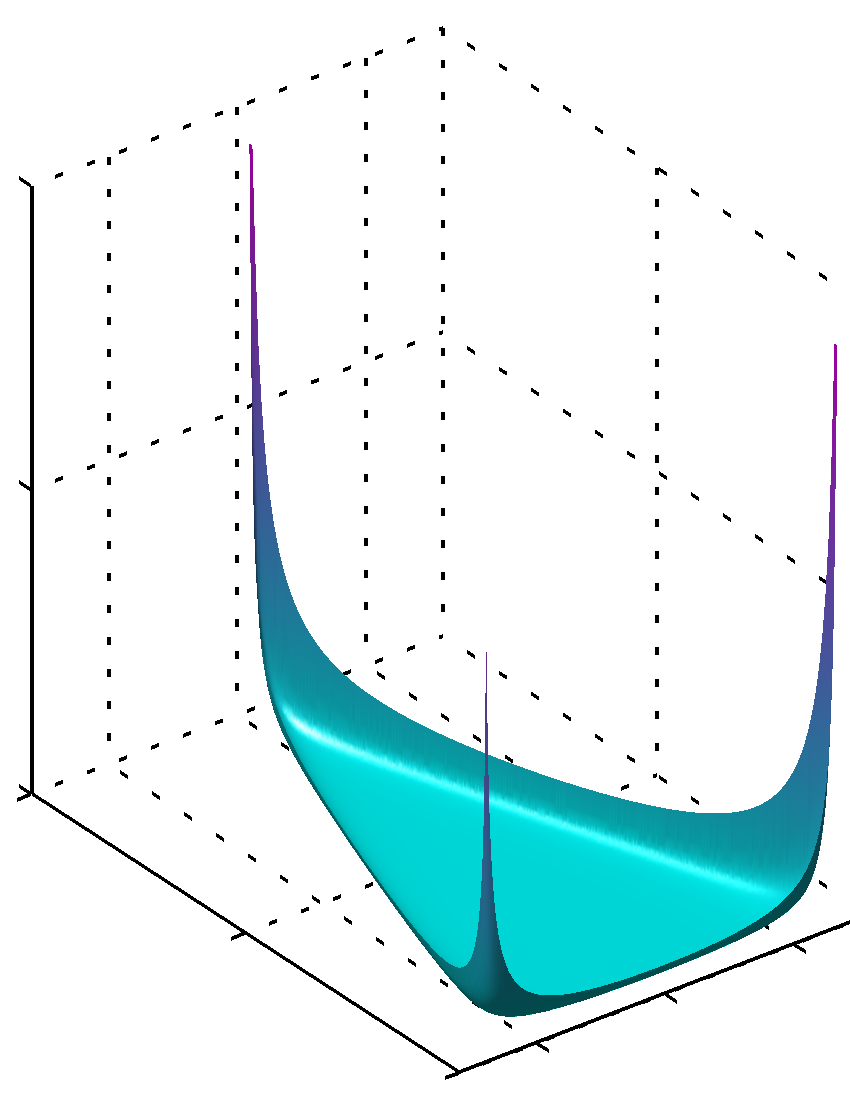

or can if all values αk are the same and greater than 1 the maximum will be found in center like
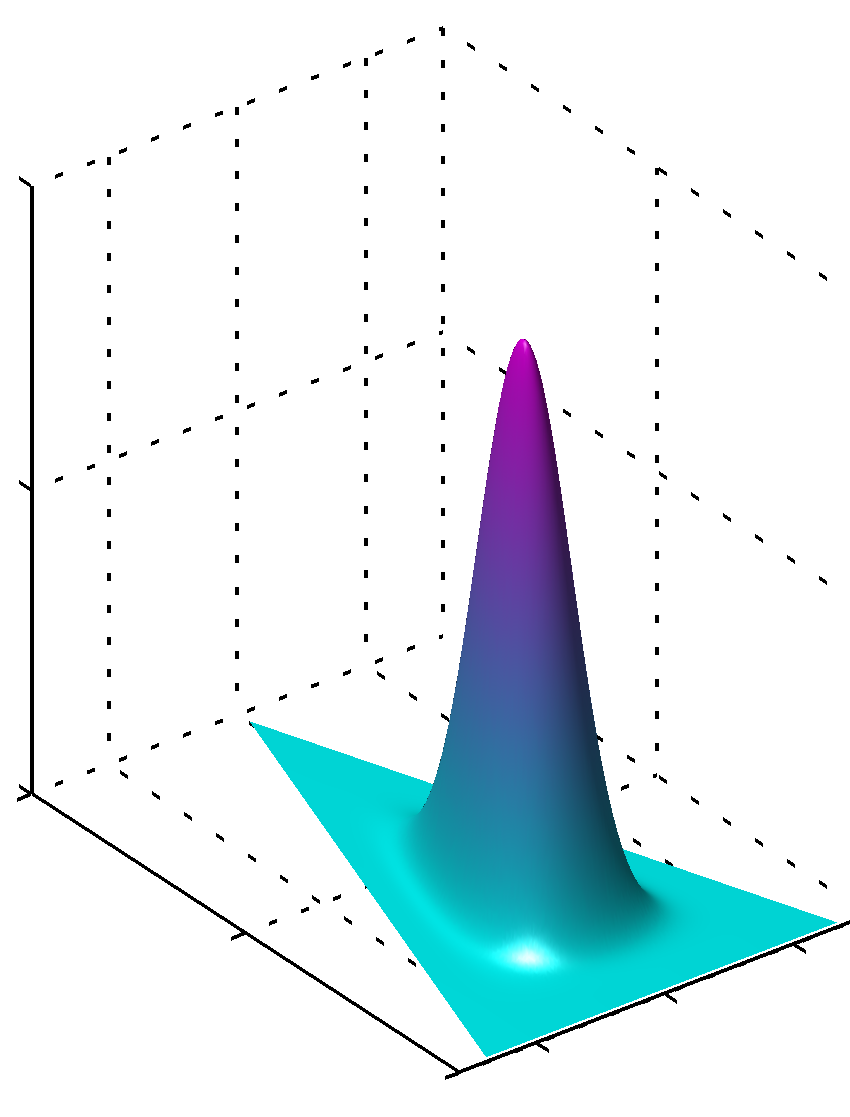


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

no_features = 10000


#tfidf_vectorizer = TfidfVectorizer( max_df=0.15,  min_df=2,  max_features=no_features)

#X = tfidf_vectorizer.fit_transform(text_train)
#feature_names = np.array(tfidf_vectorizer.get_feature_names())



vect = CountVectorizer(max_features=no_features, max_df=.15)
X = vect.fit_transform(text_train)


# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

max_df : float in range [0.0, 1.0] or int, default=1.0
    When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold (corpus-specific
    stop words).

In [218]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                doc_topic_prior=0.005, # a low alpha --> each document composed of only a few dominant topics
                                topic_word_prior=0.005,  # a low betha --> each topic composed of only a few dominant words
                                learning_method="online",
                                learning_offset=50.,
                                max_iter=25,
                                random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [20]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


In [21]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

In [22]:
#fonction du livre introduction_to_ml_with_python-master

def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [23]:
# Print out the 10 topics:

print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=2, n_words=5)

topic 0       topic 1       
--------      --------      
setosa        growth        
sympy         triplet       
tolower       ldlibrarypath 
selfvar       amet          
pylabfigure   ipsum         


topic 2       topic 3       
--------      --------      
python        characteronly 
use           libloc        
file          logicalreturn 
list          prime         
like          tup           


topic 4       topic 5       
--------      --------      
prettyprint   attachment    
yearmon       buf           
nositepackagesgmail         
dfid          smtp          
rwrr          gdb           


topic 6       topic 7       
--------      --------      
listappend    emacs         
gzipped       findall       
sysstdoutflushmount         
badly         supervisord   
rstudioserver virtualenvwrapper


topic 8       topic 9       
--------      --------      
mi            fruit         
pycairo       ni            
presave       spyder        
bare          backends      
fte

In [48]:
lda20 = LatentDirichletAllocation(n_components=20, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics20 = lda20.fit_transform(X)

In [49]:
sorting = np.argsort(lda20.components_, axis=1)[:, ::-1]

print_topics(topics=range(20), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=8, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       
--------      --------      --------      --------      --------      --------      --------      --------      
package       interval      datetime      list          column        roxygen       angle         node          
module        descend       timezone      array         plot          video         ggplotmtcars  distance      
file          sqlalchemy    datetimedatetimestring        data          attach        wt            whitespace    
install       datetimedate  timestamp     value         row           queue         star          setosa        
import        boto          separator     element       dataframe     vignette      modwsgi       pycharm       
python        join          zone          python        value         managepy      average       lead          
instal        confidence    convert       way           frame         stats         mpg       

In [27]:
# sort by weight of "function" topic 36
function = np.argsort(document_topics20[:, 63])[::-1]
# print the five documents where the topic is most important
for i in function[:5]:
    # show first two sentences
    print(".".join(text_train[i].split(".")[:2]) + ".\n")

invalidoperationexception python invalidoperationexception python.

card pyscard use readerwriter card sle read card example world apdu xff xxxx x x response sw cardserviceconnectiontransmit apdu xffxaxxxx response sw cardserviceconnectiontransmit apdu xffxbxxax response sw cardserviceconnectiontransmit apdu response apdu xff xdxxaxxaxxaxxaxxaxxa response sw cardserviceconnectiontransmit apdu response connect ccid reader atr b ff ff ff b ff ff ff ff ff ff ff ff ff ff.

plot color map zip code r python u data would like plot zipcode area state region eg city area would annotate color andor text area output would httpmapshugeinfo annotated text b pdf output c r python package code allows.

plot color map zip code r python u data would like plot zipcode area state region eg city area would annotate color andor text area output would httpmapshugeinfo annotated text b pdf output c r python package code allows.

production apache modwsgi nginx modwsgi use medium python wsgi application apach

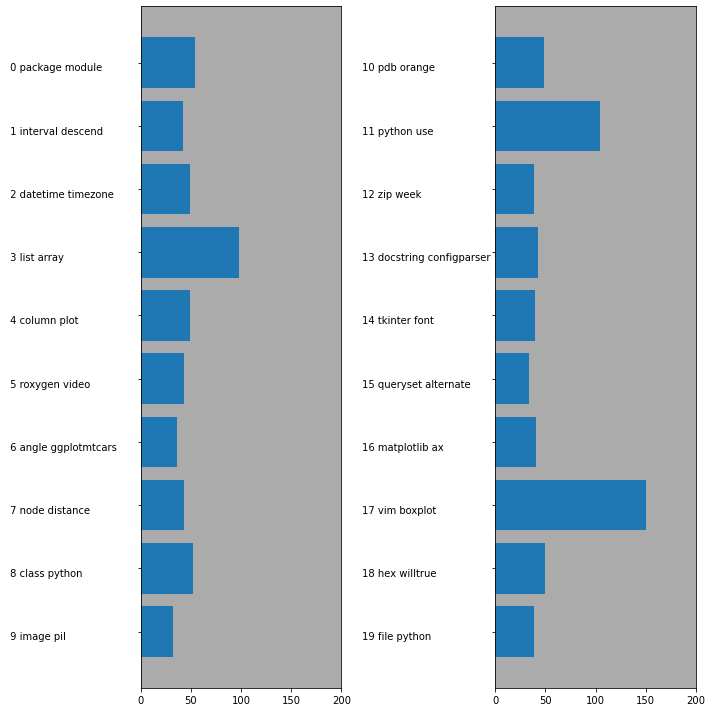

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 10
    end = (col + 1) * 10
    ax[col].barh(np.arange(10), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(10))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 200)
    ax[col].patch.set_facecolor('#ababab')
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
fig.patch.set_facecolor('w')


In [29]:
### Utiliser le modèle LDA entrainé pour faire des prédictions et proposer des nouveaux mots
#catégoriser nouvelles entrés avec le modèle entrainé
#new_post = ['I love this movie and never get tired of watching. The music in it is great.']
new_post = [text_train[35]] # test sur des post du dataset
new_post_vect = tfidf_vectorizer.transform(new_post)
post_topics100 = lda100.transform(new_post_vect)
rating = np.sort(post_topics100[0,:])[::-1][:2]
tag = np.argsort(post_topics100[0,:])[::-1][:2]
print(new_post[0])
print(rating)
print_topics(topics=tag, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=5)

difference text iof python window know file use rb instead r windows behave differently file understand exactly happen file way distinction even operate system seem treat kind file
[0.297 0.274]
topic 44      topic 88      
--------      --------      
use           file          
python        python        
function      module        
would         line          
like          script        




## NMF - No-Negative Matrix Factorisation

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

no_features = 10000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
    min_df=2, 
    max_features=no_features, 
    stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(text_train)
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

nmf_topics = nmf.transform(tfidf)

no_top_words = 5

sorting_nmf = np.argsort(nmf.components_, axis=1)[:, ::-1]
print_topics(topics=range(10), feature_names=tfidf_feature_names,
                           sorting=sorting_nmf, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
python        list          column        class         string        
use           element       data          def           character     
run           item          row           method        convert       
code          comprehension frame         initself      python        
import        way           dataframe     object        remove        
way           index         df            instance      split         
module        tuples        na            model         like          
print         want          date          return        number        
script        sort          like          attribute     format        
like          like          vector        print         word          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
file

In [31]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join(
            [feature_names[i] for i in topic.argsort()[::-1][:no_top_words]]))

display_topics(nmf, tfidf_feature_names, no_top_words)


Topic 0:
python use run code import
Topic 1:
list element item comprehension way
Topic 2:
column data row frame dataframe
Topic 3:
class def method initself object
Topic 4:
string character convert python remove
Topic 5:
file line read import directory
Topic 6:
array index element numpy matrix
Topic 7:
plot ggplot label color matplotlib
Topic 8:
function return def argument parameter
Topic 9:
value key return na vector


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

no_features = 10000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
    min_df=2, 
    max_features=no_features, 
    stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(text_train)
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())

no_topics = 20

# Run NMF
nmf_20 = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_20.fit(tfidf)

nmf_topics_20 = nmf_20.transform(tfidf)

no_top_words = 5

sorting_nmf_20 = np.argsort(nmf_20.components_, axis=1)[:, ::-1]
print_topics(topics=range(20), feature_names=tfidf_feature_names,
                           sorting=sorting_nmf_20, topics_per_chunk=8, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       
--------      --------      --------      --------      --------      --------      --------      --------      
python        list          column        class         string        file          array         plot          
use           element       row           def           character     directory     index         ggplot        
run           item          dataframe     method        convert       read          element       label         
script        comprehension df            initself      remove        path          numpy         color         
way           index         panda         instance      split         csv           matrix        matplotlib    
code          tuples        columns       object        python        folder        like          legend        
like          way           matrix        attribute     like          zip           size        

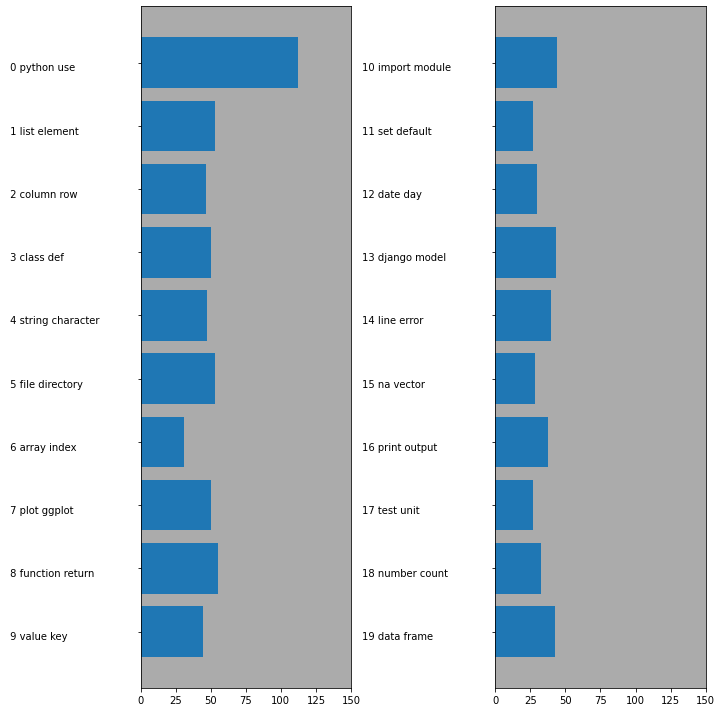

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(tfidf_feature_names[sorting_nmf_20[:, :2]])]
# two column bar chart:

for col in [0, 1]:
    start = col * 10
    end = (col + 1) * 10
    ax[col].barh(np.arange(10), np.sum(nmf_topics_20, axis=0)[start:end])
    ax[col].set_yticks(np.arange(10))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 150)
    ax[col].patch.set_facecolor('#ababab')
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
fig.patch.set_facecolor('w')


In [34]:
### Utiliser le modèle NMF entrainé pour faire des prédictions et proposer des nouveaux mots
#catégoriser nouvelles entrés avec le modèle entrainé
#new_post = ['I love this movie and never get tired of watching. The music in it is great.']
new_post = [text_train[25]] # test sur des post du dataset
new_post_vect = tfidf_vectorizer.transform(new_post)
post_topics100 = nmf.transform(new_post_vect)
rating = np.sort(post_topics100[0,:])[::-1][:2]
tag = np.argsort(post_topics100[0,:])[::-1][:2]
print(new_post[0])
print(rating)
print_topics(topics=tag, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=5)

django pattern start root spread across file wonder standard url pattern spread across file case projectwide imagine project look like get work djangoconfurls import pattern include adminautodiscover pattern registrationviewssignup registrationviewsconfirm urlruserprofiled profileviewsshow profileviewsedit see two apps want urls user use include question split two seperate urlspy file go note disregard syntax mistake type
[0.026 0.012]
topic 5       topic 0       
--------      --------      
permutation   online        
myfun         setosa        
five          party         
wrapper       specie        
measurement   rd            




In [35]:
from sklearn.manifold import TSNE

vect = CountVectorizer(max_features=10000, max_df=.15)
X_tsne = vect.fit_transform(text_train)

tsne5 = TSNE(n_components=2, random_state=42,perplexity=5, n_jobs=-1)
tsne50 = TSNE(n_components=2, random_state=42,perplexity=50, n_jobs=-1)
df_reduced_tsne5 = tsne5.fit_transform(X_tsne)
# df_reduced_tsne50 = tsne50.fit_transform(X)

In [36]:
tSNE_perplexity = 't-SNE perplexity=5'

df_reduced_tsne = df_reduced_tsne5
df_reduced_tsne.shape

(10000, 2)

In [219]:
y_pred_lda = lda.transform(X)
y_pred_nmf = nmf.transform(tfidf)
y_pred_lda

array([[0.04 , 0.   , 0.   , ..., 0.905, 0.   , 0.   ],
       [0.   , 0.508, 0.   , ..., 0.409, 0.   , 0.047],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.05 , 0.053, 0.044, ..., 0.   , 0.   , 0.   ],
       [0.067, 0.257, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.997, 0.   , ..., 0.   , 0.   , 0.   ]])

In [220]:
tag_lda = np.argsort(y_pred_lda[:,:],axis=1)[:,::-1][:,:1]
score_lda = np.sort(y_pred_lda[:,:],axis=1)[:,::-1][:,:2]


In [221]:
tag_nmf = np.argsort(y_pred_nmf[:,:],axis=1)[:,::-1][:,:1]
score_nmf = np.sort(y_pred_nmf[:,:],axis=1)[:,::-1][:,:2]


In [222]:
LDA_sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
NMF_sorting = np.argsort(nmf.components_, axis=1)[:, ::-1]

In [223]:
LDA_catétories_Tags = []
for i in range(LDA_sorting.shape[0]):
    LDA_catétories_Tags.append([feature_names[LDA_sorting[i,0]],
                            feature_names[LDA_sorting[i,1]],
                            feature_names[LDA_sorting[i,2]],
                            feature_names[LDA_sorting[i,3]],
                            ])
print( 'Liste des Topics LDA')
for i in range(LDA_sorting.shape[0]):
    print('Topic ',i,' : ',LDA_catétories_Tags[i])

Liste des Topics LDA
Topic  0  :  ['list', 'print', 'import', 'element']
Topic  1  :  ['plot', 'image', 'ggplot', 'label']
Topic  2  :  ['letter', 'operator', 'age', 'chr']
Topic  3  :  ['array', 'none', 'index', 'import']
Topic  4  :  ['date', 'time', 'format', 'day']
Topic  5  :  ['string', 'column', 'number', 'row']
Topic  6  :  ['dog', 'timeout', 'cat', 'elapse']
Topic  7  :  ['class', 'def', 'run', 'call']
Topic  8  :  ['error', 'line', 'package', 'module']
Topic  9  :  ['line', 'model', 'task', 'process']


In [224]:
NMF_catétories_Tags = []
for i in range(NMF_sorting.shape[0]):
    NMF_catétories_Tags.append([tfidf_feature_names[NMF_sorting[i,0]],
                            tfidf_feature_names[NMF_sorting[i,1]],
                            tfidf_feature_names[NMF_sorting[i,2]],
                            tfidf_feature_names[NMF_sorting[i,3]],
                            ])
print( 'Liste des Topics NMF')
for i in range(NMF_sorting.shape[0]):
    print('Topic ',i,' : ',NMF_catétories_Tags[i])


Liste des Topics NMF
Topic  0  :  ['python', 'use', 'run', 'code']
Topic  1  :  ['list', 'element', 'item', 'comprehension']
Topic  2  :  ['column', 'data', 'row', 'frame']
Topic  3  :  ['class', 'def', 'method', 'initself']
Topic  4  :  ['string', 'character', 'convert', 'python']
Topic  5  :  ['file', 'line', 'read', 'import']
Topic  6  :  ['array', 'index', 'element', 'numpy']
Topic  7  :  ['plot', 'ggplot', 'label', 'color']
Topic  8  :  ['function', 'return', 'def', 'argument']
Topic  9  :  ['value', 'key', 'return', 'na']


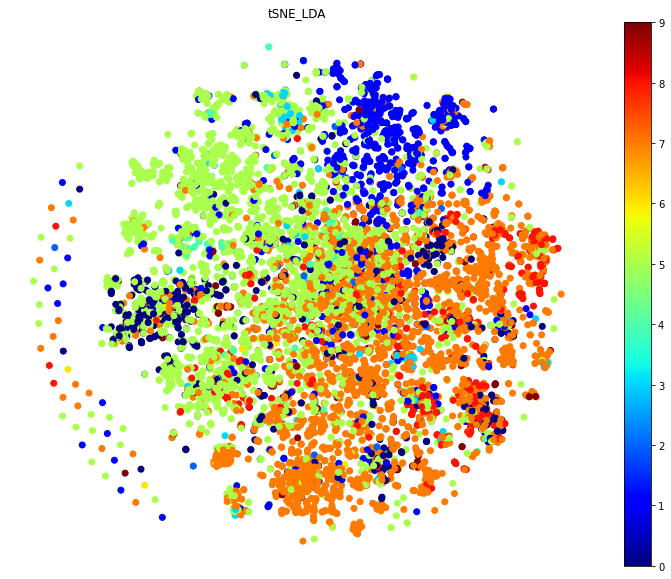

In [225]:
fig = plt.figure(figsize=(13, 10))
fig.patch.set_facecolor('w')
#plt.figure(figsize=(13, 10))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=tag_lda, cmap="jet")
plt.title('tSNE_LDA')
plt.axis('off')
plt.colorbar()
plt.show()

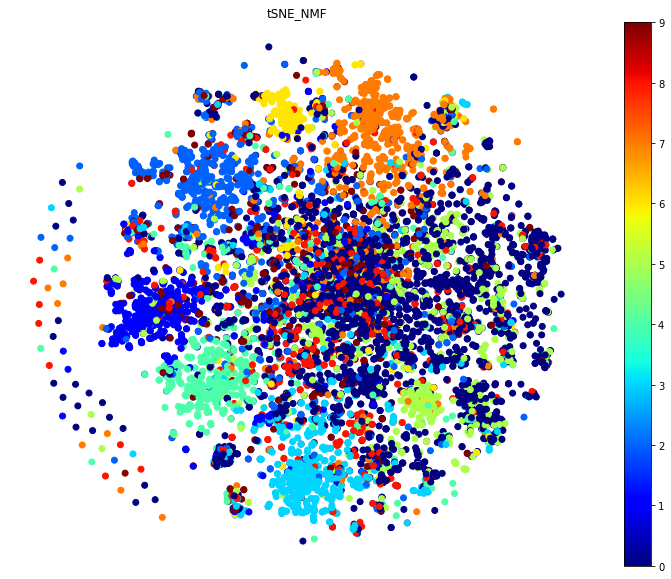

In [226]:
fig = plt.figure(figsize=(13, 10))
fig.patch.set_facecolor('w')
#plt.figure(figsize=(13, 10))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=tag_nmf, cmap="jet")
plt.title('tSNE_NMF')
plt.axis('off')
plt.colorbar()
plt.show()


In [230]:
color_lda = np.zeros(tag_lda.shape)
for i in range(len(color_lda)):
    if tag_lda[i]==7:
        color_lda[i]=1
        
color_nmf = np.zeros(tag_lda.shape)
for i in range(len(color_nmf)):
    if tag_nmf[i]==0:
        color_nmf[i]=1

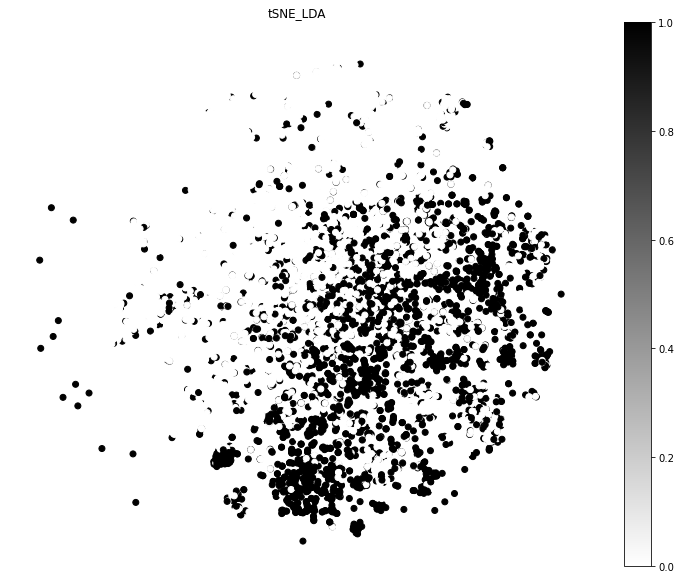

In [231]:
fig = plt.figure(figsize=(13, 10))
fig.patch.set_facecolor('w')
#plt.figure(figsize=(13, 10))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=color_lda, cmap="binary")
plt.title('tSNE_LDA')
plt.axis('off')
plt.colorbar()
plt.show()

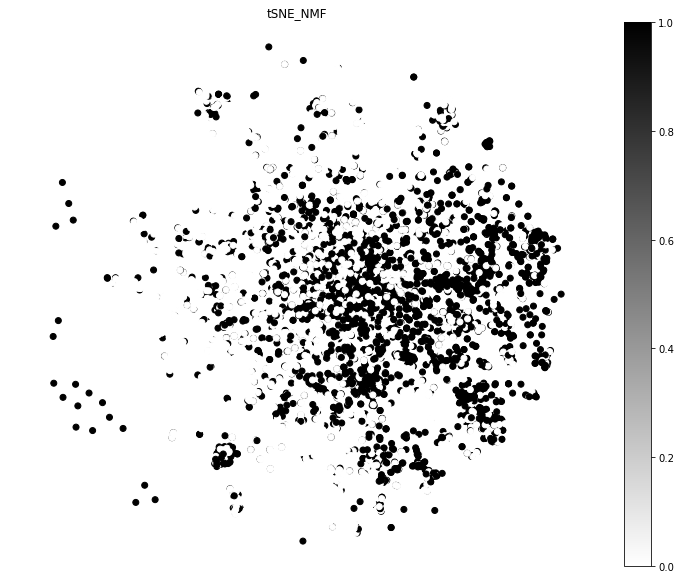

In [232]:
fig = plt.figure(figsize=(13, 10))
fig.patch.set_facecolor('w')
#plt.figure(figsize=(13, 10))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=color_nmf, cmap="binary")
plt.title('tSNE_NMF')
plt.axis('off')
plt.colorbar()
plt.show()
